In [1]:
import pandas as pd
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import nd2
import cc3d
import pickle

from scipy import signal
from scipy import stats
from scipy import ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

from skimage.util import img_as_float, img_as_int
from skimage.feature import peak_local_max
from skimage import filters

from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import morphology
from skimage.filters import threshold_multiotsu, threshold_otsu, sobel
from skimage.segmentation import watershed, expand_labels, mark_boundaries, clear_border, random_walker
from skimage.filters import rank, laplace, gaussian
from skimage.measure import regionprops, regionprops_table
from skimage import measure
from skimage import restoration
from skimage.exposure import rescale_intensity
from skimage.draw import disk

In [2]:
def getimfolder(experiment):
    import os
    basedir = ""
    data = "E:\Raphael\Data"
    for folder in os.listdir(data):
        if str(experiment) in folder:
            basedir = os.path.join(data, folder)
    return basedir

experiment = 7
rep = 1
PID = 0
NDID = 0
stack = 0
Group1 = "FY"
Group2 = "LAMP1"
Channel1 = "DAPI"
Channel2 = "GFP"
Channel3 = "568_2"

basedir = getimfolder(experiment)
info = os.path.join(basedir, "Info.xlsx")
#idf = pd.read_excel(info)

In [151]:
def readimages(rawdir, splitdir, ID, NDID,rep):
    import os
    import tifffile as tiff
    import nd2
    data = {"ID":[], "PID":[], "Channel": [], "ChID": [], "xlen": [], "ylen":[], "zlen": [], "Group1":[], "Group2":[], "NDID":[],"Rep":[]}
    for ndimg in os.listdir(rawdir):
        print(ndimg)
        PID = 0
        iml = os.path.join(rawdir, ndimg)
        with nd2.ND2File(iml) as ndfile:
            meta = ndfile.metadata
            shape = ndfile.shape
            for series in range(shape[0]):
                for i in range(len(meta.channels)):
                    chan = meta.channels[i].channel.name
                    ch = ""
                    if chan in ["594"]:
                        ch = "ConcanavalinA"
                    elif chan in ["DAPI"]:
                        ch = "DAPI"
                    elif chan in ["GFP"]:
                        ch = "aSyn_GFP"
                    else:
                        continue
                    #img = ndfile.asarray(PID)
                    #img = img[:,:,i,:,:]
                    #tiff.imwrite(os.path.join(splitdir,str(ID))+".tif", img)
                    xlen, ylen, zlen = meta.channels[i].volume.axesCalibration
                    data["ID"].append(str(ID))
                    data["PID"].append(str(PID))
                    data["NDID"].append(NDID)
                    data["Channel"].append(str(ch))
                    data["ChID"].append(i)
                    data["xlen"].append(xlen)
                    data["ylen"].append(ylen)
                    data["zlen"].append(zlen)
                    data["Group1"].append(ndimg.split("_")[0])
                    data["Group2"].append(ndimg.split("_")[1].split(".")[0])
                    data["Rep"].append(rep)

                    ID = ID+1
                NDID+=1
                PID = PID+1
    return data

def splitimages(experiment, rep):
    import os
    import pandas as pd
    basedir = getimfolder(experiment)
    rawdir = os.path.join(basedir,str(rep))
    splitdir = os.path.join(basedir,"Images")
    info = os.path.join(basedir, "Info.xlsx")
    if os.path.exists(info) == True:
        old_df = pd.read_excel(info)
        ID = max(old_df["ID"])
        NDID = max(old_df["NDID"])
        data = readimages(rawdir, splitdir, ID, NDID,rep)
        new_df = pd.DataFrame(data = data)
        print(len(new_df))
        df = pd.concat([old_df,new_df])
        df = df.drop(df[df["Channel"] == "DIA Confocal"].index)
    else:
        ID = 0
        data = readimages(rawdir, splitdir, ID, 0,rep)
        df = pd.DataFrame(data = data)
        print(len(df))
        df = df.drop(df[df["Channel"] == "DIA Confocal"].index)
    df.to_excel(info,index=False)
    
for repi in range(1):
    repi = repi+1
    print(repi)
    splitimages(experiment, repi)

1
BL_BL.nd2
TP_CQ.nd2
X_Ctrl.nd2
450


In [152]:
def getImage(df, ID, basedir):
    imdir = os.path.join(basedir, str(df["Rep"][df["ID"]==ID].values[0]))
    string = str(df["Group1"][df["ID"]==ID].values[0])+"_"+str(df["Group2"][df["ID"]==ID].values[0])
    for ndimg in os.listdir(imdir):
        if string in ndimg:
            iml = os.path.join(imdir,ndimg)
            with nd2.ND2File(iml) as ndfile:
                print(ndfile)
                img = ndfile.to_dask()
                i = df["ChID"][df["ID"]==ID].values[0]
                p = df["PID"][df["ID"]==ID].values[0]
                img = img[p,i,:,:]
                img = np.array(img)
                return img

In [153]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [154]:
def rescale_before(img, pixlenimg):
    from skimage.transform import rescale
    pixlensd = 0.3488
    scaling_factor = pixlenimg/pixlensd
    image_rescaled = rescale(img, scaling_factor, anti_aliasing=True)
    return image_rescaled

def rescale_after(img, dims):
    from skimage.transform import resize
    image_resized = resize(img, dims, preserve_range=True, order=0, anti_aliasing=False).astype('uint8')
    return image_resized

def segment_cells(cells, labels):
    t = threshold_multiotsu(cells)
    minimg = np.min(cells)
    binary = cells > (2*t[0]+minimg)/3
    binary = ndi.binary_fill_holes(binary)
    cellL = watershed(-cells, markers = labels, mask = binary)
    return cellL

def segment_slice(DAPIimg,CELLimg,xlen, model):
    if model == None:
        model = StarDist2D.from_pretrained('2D_versatile_fluo')
    img_rescaled_DAPI = rescale_before(DAPIimg, xlen)
    labelssd, _ = model.predict_instances(normalize(img_rescaled_DAPI))
    cells = segment_cells(rescale_before(CELLimg, xlen),labelssd)
    labels_rescaled = rescale_after(labelssd, DAPIimg.shape)
    cellL = rescale_after(cells, CELLimg.shape)
    return labels_rescaled,cellL


    


<ND2File at 0x1e85b1f5be0: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e85b0c93a0: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e85afbaf70: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
1/1 [==============================] - 1s 926ms/step


TypeError: scatter() missing 1 required positional argument: 'y'

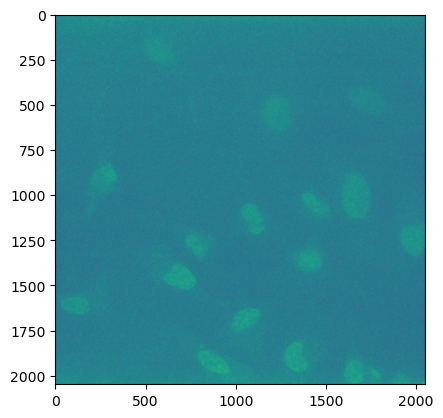

In [117]:
NDID = 0

xlen = idf["xlen"][idf["NDID"]==NDID].unique()[0]

coordinates = peak_local_max(GFPimg, min_distance=20)
plt.imshow(GFPimg)
plt.scatter(coordinates)
plt.show()

<ND2File at 0x1e85b3ce610: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>


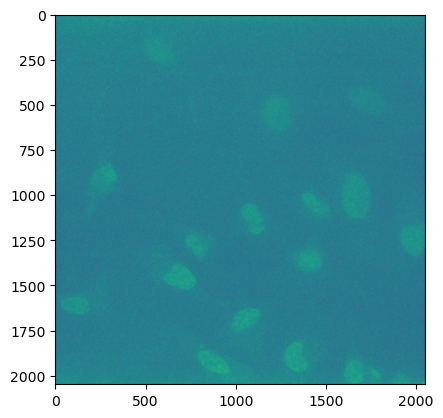

In [126]:


plt.plot(coordinates[0],coordinates[1],'r.')
plt.imshow(GFPimg)
plt.show()

In [179]:
def measure_final(basedir):
    print("Hey")
    idf = pd.read_excel(os.path.join(basedir, "Info.xlsx"))
    cdf = pd.DataFrame()
    sdf = pd.DataFrame()
    cdfs = []
    sdfs = []
    max_CID = 0
    max_SID = 0
    if os.path.exists(os.path.join(basedir, "CellInfo.csv")):
        cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
        print(cdf["NDID"].unique())
        idf = idf[~idf['NDID'].isin(cdf["NDID"].unique())]
        max_CID = cdf["CID"].max()+1
        cdfs = [cdf]
    if os.path.exists(os.path.join(basedir, "SpotsInfo.csv")):
        sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))
        print("Hey")
        max_SID = cdf["SID"].max()+1
        sdfs = [sdf]
    for NDID in idf["NDID"].unique():
        print(NDID)
        xlen = idf["xlen"][idf["NDID"]==NDID].unique()[0]
        DAPIimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="DAPI"].values[0]), basedir)
        CELLimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="ConcanavalinA"].values[0]), basedir)
        GFPimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="aSyn_GFP"].values[0]), basedir)
        nL, cL = segment_slice(DAPIimg,CELLimg,xlen, model)
        tcdf = pd.DataFrame(regionprops_table(cL,intensity_image=GFPimg,properties = ('label', 'bbox', "intensity_max","intensity_min","intensity_mean")))
        tcdf["NDID"] = NDID
        tcdf["CID"] = tcdf["label"]+max_CID
        max_CID = tcdf["CID"].max()+1
        t = np.median(GFPimg)*3
        coordinates = peak_local_max(GFPimg, min_distance=20,threshold_abs = t).T
        if coordinates.shape[1] != 0:
            coordL = cL[coordinates[0],coordinates[1]]
            tsdf = pd.DataFrame()
            tsdf["x"] = coordinates[0]
            tsdf["y"] = coordinates[1]
            tsdf["label"] = coordL
            CIDs = tsdf.join(tcdf, on = "label", rsuffix = "abd")["CID"]
            tsdf["CID"] = CIDs
            tsdf["SID"] = tsdf.index + max_SID
            max_SID = tsdf["SID"].max()+1
            sdfs.append(tsdf)
            sdf = pd.concat(sdfs)
            sdf.to_csv(os.path.join(basedir, "SpotsInfo.csv"))
        cdfs.append(tcdf)
        cdf = pd.concat(cdfs)
        cdf.to_csv(os.path.join(basedir, "CellInfo.csv"))
    return tcdf
    
print(measure_final(basedir))

Hey
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
51
<ND2File at 0x1e85b37efd0: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e867a6dee0: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e85b37eb50: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
1/1 [==============================] - 0s 454ms/step
52
<ND2File at 0x1e867a5cf10: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e867a5c820: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e85d803400: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
1/1 [==============================] - 0s 439ms/step
53
<ND2File at 0x1e867a5d640: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e85b3e2520: 'TP_CQ.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
<ND2File at 0x1e867a

In [184]:
df = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))
df.head()
print(len(df))

198


<ND2File at 0x1e85a89da30: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
1/1 [==============================] - 0s 465ms/step


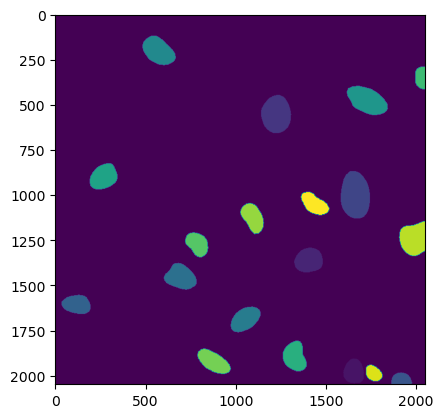

In [105]:
idf =  pd.read_excel(os.path.join(basedir, "Info.xlsx"))

ID = 1
testnuc = getImage(idf, ID, basedir)
xlen = idf["xlen"][idf["NDID"]==NDID].unique()[0]
labels = segment_nuclei_slice(testnuc,xlen, model)
plt.imshow(labels)

<ND2File at 0x1e85ada12e0: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>


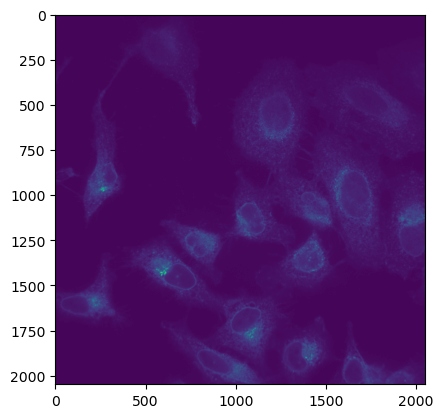

In [107]:

ID = 2
testimg = getImage(idf, ID, basedir)

plt.imshow(testimg)

<ND2File at 0x1e85d7ce7c0: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>
[166 278]


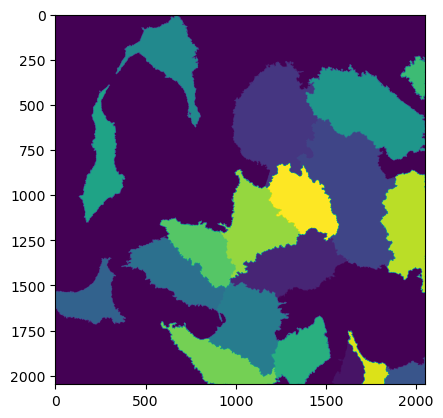

In [106]:
ID = 2
testimg = getImage(idf, ID, basedir)
t = threshold_multiotsu(testimg)
print(t)
minimg = np.min(testimg)
binary = testimg > (2*t[0]+minimg)/3
binary = ndi.binary_fill_holes(binary)
cells = watershed(-testimg, markers = labels, mask = binary)
plt.imshow(cells)

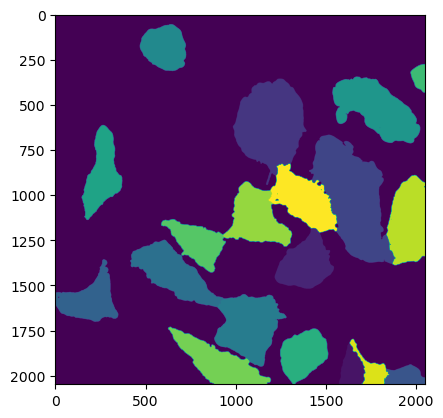

In [76]:
plt.imshow(seg)

<ND2File at 0x1e8531e7100: 'BL_BL.nd2' uint16: {'P': 50, 'C': 3, 'Y': 2048, 'X': 2048}>


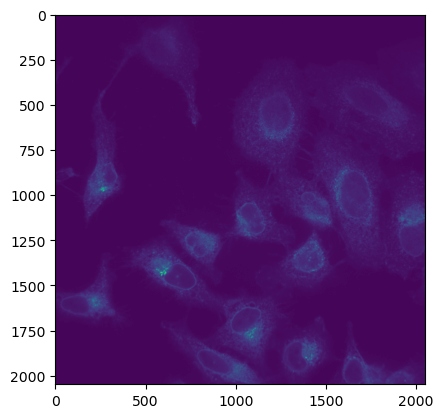

In [52]:
testimg = getImage(idf, ID, basedir)
plt.imshow(testimg)

Removing edges:

In [19]:
idf= pd.read_excel(os.path.join(basedir, "Info.xlsx"))
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
print(len(cdf))
print(cdf["bbox-2"].max())
for c in cdf.columns.values:
    if "bbox" in c:
        cdf = cdf[cdf[c]!=0]
        cdf = cdf[cdf[c]!=2048]
        print(len(cdf))
cdf.head()

11437
2048
10535
9656
8637
7686


,Unnamed: 0.1,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,intensity_max,intensity_min,intensity_mean,NDID,CID
1,1,1.0,2,1184,957,1566,1613,143.0,94.0,115.045475,0,2
2,2,2.0,3,264,979,951,1451,139.0,94.0,115.337812,0,3
3,3,3.0,4,587,1339,1411,1911,142.0,93.0,115.000729,0,4
6,6,6.0,7,1240,379,1638,945,148.0,94.0,116.108015,0,7
7,7,7.0,8,1485,848,1986,1296,143.0,94.0,115.756270,0,8


In [20]:
idf.head()

,ID,PID,Channel,ChID,xlen,ylen,zlen,Group1,Group2,NDID,Rep
0,0,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,0,1
1,1,0,DAPI,1,0.112298,0.112298,1,BL,BL,0,1
2,2,0,ConcanavalinA,2,0.112298,0.112298,1,BL,BL,0,1
3,3,1,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1,1
4,4,1,DAPI,1,0.112298,0.112298,1,BL,BL,1,1


In [48]:
sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))
sdf.astype({'CID': 'int8'},errors = "ignore" )
print(sdf["CID"].unique())
pointcount = sdf["CID"].value_counts()

[ 1609.  1658.  1633.  1647.  1641.  1699.    nan  1708.  1836.  1846.
  1850.  1858.  1888.  1880.  1902.  1975.  2020.  2050.  2052.  2094.
  2121.  2147.  2139.  2172.  2214.  2235.  2222.  2257.  2384.  2412.
  2437.  2428.  2447.  2439.  2513.  2525.  2497.  2565.  2630.  2640.
  2643.  2723.  2769.  2745.  2756.  2938.  2987.  3083.  3210.  3233.
  3211.  3234.  3291.  3284.  3269.  3403.  3509.  3521.  3585.  3649.
  3647.  3646.  3660.  3673.  3688.  3698.  3715.  3739.  3830.  3880.
  3876.  3915.  3952.  3935.  4066.  4058.  4403.  4394.  4448.  4511.
  4509.  4531.  4584.  4806.  4823.  5041.  5147.  5396.  5681.  5753.
  5828.  7470.  7519.  7494.  7508.  7502.  7560.  7569.  7697.  7707.
  7711.  7719.  7749.  7741.  7763.  7836.  7881.  7911.  7913.  7955.
  7982.  8008.  8000.  8033.  8075.  8096.  8083.  8118.  8245.  8273.
  8298.  8289.  8308.  8300.  8374.  8386.  8358.  8426.  8491.  8501.
  8504.  8584.  8630.  8606.  8617.  8799.  8848.  8944.  9071.  9094.
  9072

In [58]:
df = cdf.merge(idf[idf["Channel"]=="aSyn_GFP"], on = "NDID",how='left')
df.head()

,Unnamed: 0.1,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,intensity_max,intensity_min,intensity_mean,...,ID,PID,Channel,ChID,xlen,ylen,zlen,Group1,Group2,Rep
0,1,1.0,2,1184,957,1566,1613,143.0,94.0,115.045475,...,0,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1
1,2,2.0,3,264,979,951,1451,139.0,94.0,115.337812,...,0,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1
2,3,3.0,4,587,1339,1411,1911,142.0,93.0,115.000729,...,0,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1
3,6,6.0,7,1240,379,1638,945,148.0,94.0,116.108015,...,0,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1
4,7,7.0,8,1485,848,1986,1296,143.0,94.0,115.756270,...,0,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1


In [61]:
pointcountdf = pointcount.to_frame(name="PointCounts").reset_index()
pointcountdf= pointcountdf.rename(columns={"index": "CID"})
print(pointcountdf)
print(df.columns.values)
df = df.merge(pointcountdf, on = "CID",how='left')
df['PointCounts'] = df['PointCounts'].fillna(0)
df.head()

         CID  PointCounts
0     2257.0            3
1     8118.0            3
2     8501.0            2
3     7881.0            2
4     2020.0            2
..       ...          ...
175   3673.0            1
176   3688.0            1
177   3698.0            1
178   3715.0            1
179  11689.0            1

[180 rows x 2 columns]
['Unnamed: 0.1' 'Unnamed: 0' 'label' 'bbox-0' 'bbox-1' 'bbox-2' 'bbox-3'
 'intensity_max' 'intensity_min' 'intensity_mean' 'NDID' 'CID' 'ID' 'PID'
 'Channel' 'ChID' 'xlen' 'ylen' 'zlen' 'Group1' 'Group2' 'Rep']


,Unnamed: 0.1,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,intensity_max,intensity_min,intensity_mean,...,PID,Channel,ChID,xlen,ylen,zlen,Group1,Group2,Rep,PointCounts
0,1,1.0,2,1184,957,1566,1613,143.0,94.0,115.045475,...,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1,0.0
1,2,2.0,3,264,979,951,1451,139.0,94.0,115.337812,...,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1,0.0
2,3,3.0,4,587,1339,1411,1911,142.0,93.0,115.000729,...,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1,0.0
3,6,6.0,7,1240,379,1638,945,148.0,94.0,116.108015,...,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1,0.0
4,7,7.0,8,1485,848,1986,1296,143.0,94.0,115.756270,...,0,aSyn_GFP,0,0.112298,0.112298,1,BL,BL,1,0.0


In [1]:
def first_segmentation(img, labels_rescaled):
    if len(np.unique(img)) < 3:
        return "EXIT"
    thresholds = threshold_multiotsu(img)
    thresholds[::-1].sort()
    labeled = labels_rescaled
    for t in thresholds:
        binary = img >= t
        binary[labeled != 0] = True
        labeled = watershed(-img, markers = labeled, mask = binary)
    return labeled



In [ ]:
def crop(image, label, df):
    r = df[df["label"] == label]
    cimage = image[int(r["bbox-0"].values):int(r["bbox-2"].values),int(r["bbox-1"].values):int(r["bbox-3"].values)]
    return cimage

def reversecrop(zeros, insert, label, df):
    r = df[df["label"] == label]
    zeros[int(r["bbox-0"].values):int(r["bbox-2"].values),int(r["bbox-1"].values):int(r["bbox-3"].values)] = insert
    return zeros


In [ ]:
def second_segmentation(img, labeled):
    tempprops =  measure.regionprops_table(labeled, img, properties=['label', 'bbox','intensity_mean'])
    finallabel = np.zeros(labeled.shape, dtype = np.uint8)
    propdf = pd.DataFrame(tempprops)
    propdf = propdf.sort_values(by=['intensity_mean'], ascending=False)
    LLabel = propdf.loc[:,"label"].values
    for i in range(len(LLabel)):
        l = LLabel[i]
        mask_crop = crop(labeled, l, propdf)
        cropped = crop(img, l, propdf)
        t = threshold_multiotsu(cropped)
        labels = np.zeros(mask_crop.shape)
        labels[mask_crop == l] = 0
        labels[cropped > t[0]] = l
        labels[mask_crop != l] = l+1
        elevation_map = sobel(cropped)
        seg = watershed(elevation_map, labels)
        seg[seg == l+1] = 0
        segup = np.zeros(finallabel.shape, dtype = np.uint8)
        segup = reversecrop(segup, seg, l, propdf)
        segup[finallabel > 0] = 0
        finallabel = finallabel + segup
    return finallabel



In [ ]:
def addnuclei(labeledcells, labelednuclei):
    addition = labeledcells
    addition[labelednuclei > 0] = 0
    addition += labelednuclei
    return addition


In [2]:
def remove_edges(celllabel, nucleilabel):
    necells = clear_border(celllabel)
    necells = morphology.remove_small_objects(necells, 64)
    nenuclei = nucleilabel
    for l in np.unique(nucleilabel):
        if l not in np.unique(necells):
            nenuclei[nenuclei == l] = 0
    return necells, nenuclei

In [ ]:
def segment_stack(df, IDN, model, basedir):
    print("before seg nuclei")
    labels_nuclei, DAPI = segment_nuclei_stack(df,IDN, model, basedir)
    GFP = getImage(df, IDN-2, basedir)
    Ln = np.zeros(labels_nuclei.shape, dtype = np.uint8)
    Lc = np.zeros(GFP.shape, dtype = np.uint8)
    for i in range(GFP.shape[0]):
        print("beforesegcell")
        first_seg = first_segmentation(np.array(GFP), np.array(labels_nuclei))
        if first_seg == "EXIT":
            return "EXIT", "EXIT"
        second_seg = second_segmentation(np.array(GFP), first_seg)
        final_seg = addnuclei(second_seg, np.array(labels_nuclei))
        celllabel, nucleilabel = remove_edges(second_seg, np.array(labels_nuclei))
        Ln = nucleilabel
        Lc = celllabel
    return Lc, Ln, GFP, DAPI

In [ ]:
def measure_cells(celllabel, nucleilabel, GFP, DAPI):
    cellprops = regionprops_table(np.array(celllabel), np.array(GFP), properties=['label', 'bbox','intensity_mean', "Area", "centroid","intensity_max"])
    dfc = pd.DataFrame(cellprops)
    #dfc = getvarLaplace(GFP, celllabel, dfc)
    nucleiprops = regionprops_table(np.array(nucleilabel), np.array(DAPI), properties=['label','intensity_mean', "Area", "centroid"])
    dfn = pd.DataFrame(nucleiprops)
    #dfn = getvarLaplace(DAPI, nucleilabel, dfn)
    df = dfc.merge(dfn, "inner", on = "label", suffixes = ("_cell","_nucleus"))
    df["N:C"] = df["Area_nucleus"]/df["Area_cell"]
    df["Include"] = True
    df = df.drop(df[df["N:C"] > 0.9].index)
    return df


In [ ]:
def save_cells(new_df, basedir):
    cinfo = os.path.join(basedir, "CellInfo.csv")
    if os.path.exists(cinfo) == True:
        old_df = pd.read_csv(cinfo)
        if np.max(new_df["NDID"]) <= np.max(old_df["NDID"]):
              return cinfo
        oldID = max(old_df["CID"])
        new_df["CID"] = new_df["CID"]+oldID+1
        new_df = new_df.drop(new_df[new_df["NDID"] == max(old_df["NDID"])].index)
        cdf = pd.concat([old_df,new_df])
        cdf.to_csv(cinfo,index=False)
    else:
        new_df.to_csv(cinfo,index=False)
    return cinfo


In [ ]:
def segment_cells(idf, NDID, basedir, model):
    r = idf[idf["NDID"] == NDID]
    print(r)
    DAPI_ID = int(r["ID"][r["Channel"]=="DAPI"].values)
    print("before seg")
    Lc, Ln, GFP_img, DAPI_img = segment_stack(idf, DAPI_ID, model, basedir)
    if Lc == "EXIT":
        return "EXIT","EXIT","EXIT","EXIT"
    dfs = []
    for i in range(Lc.shape[0]):
        df = measure_cells(Lc, Ln, GFP_img, DAPI_img)
        df["NDID"] = NDID
        CID = df["label"].values
        df["CID"] = CID
        dfs.append(df)
    cdf = pd.concat(dfs)
    cinfo = save_cells(cdf, basedir)
    return cinfo, pinfo, Lc, Ln